<a href="https://colab.research.google.com/github/NazaninFarzady/DeepLearning_Ebay/blob/TrainingModel/ReplicateImageSegmentationWithFC-DeepLabV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Applications of Foreground-Background separation with Semantic Segmentation

1. Load the model

Let’s load up the FCN!

In [1]:
from torchvision import models
fcn = models.segmentation.fcn_resnet101(pretrained=True).eval()

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth


Downloading: "https://download.pytorch.org/models/fcn_resnet101_coco-7ecb50ca.pth" to /root/.cache/torch/checkpoints/fcn_resnet101_coco-7ecb50ca.pth


We have a pretrained model of FCN with a Resnet101 backbone. The pretrained=True flag will download the model if it is not already present in the cache. The .eval method will load it in inference mode.

2. Load the Image

let’s get an image! We download an image of a bird directly from a URL and save it. We use PIL to load the image

2020-04-06 11:25:15 URL:https://static.independent.co.uk/s3fs-public/thumbnails/image/2018/04/10/19/pinyon-jay-bird.jpg [182965/182965] -> "bird.png" [1]


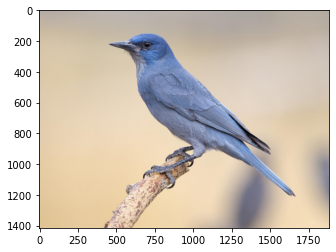

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import torch

!wget -nv https://static.independent.co.uk/s3fs-public/thumbnails/image/2018/04/10/19/pinyon-jay-bird.jpg -O bird.png
img = Image.open('./bird.png')
plt.imshow(img); plt.show()

3. Pre-process the image

In order to get the image into the right format for inference using the model, we need to pre-process it and normalize it!

for the pre-processing steps, we carry out the following.

1. Resize the image to (256 x 256)

2. CenterCrop it to (224 x 224)

3. Convert it to Tensor – all the values in the image will be scaled so that will lie between [0, 1]instead of the original, [0, 255] range.

4. Normalize it with the Imagenet specific values mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]

5. We unsqueeze the image so that it becomes [1 x C x H x W] from [C x H x W]. This is required since we need a batch while passing it through the network.

In [0]:
# Apply the transformations needed
import torchvision.transforms as T
trf = T.Compose([T.Resize(256),
                 T.CenterCrop(224),
                 T.ToTensor(), 
                 T.Normalize(mean = [0.485, 0.456, 0.406], 
                             std = [0.229, 0.224, 0.225])])
inp = trf(img).unsqueeze(0)

T.Compose is a function that takes in a list in which each element is of transforms type and it returns an object through which we can pass batches of images and all the required transforms will be applied to the images.

T.Resize(256) : Resizes the image to size 256 x 256

T.CenterCrop(224) : Center Crops the image to have a resulting size of 224 x 224

T.ToTensor() : Converts the image to type torch.Tensor and scales the values to [0, 1] range

T.Normalize(mean, std) : Normalizes the image with the given mean and standard deviation.

4. Forward pass through network

Now that we have the image all preprocessed and ready, let’s pass it through the model and get the out key.
The output of the model is a OrderedDict so we need to take the out key from that to get the output of the model

In [4]:
# Pass the input through the net
out = fcn(inp)['out']
print (out.shape)

torch.Size([1, 21, 224, 224])


So, out is the final output of the model. Its shape is [1 x 21 x H x W] and since, the model was trained on 21 classes, the output has 21 channels!
Then make this 21 channelled output into a 2D image or a 1 channel image, where each pixel of that image corresponds to a class!
So, the 2D image (of shape [H x W]) will have each pixel corresponding to a class label, and thus for each (x, y) pixel in this 2D image will correspond to a number between 0 - 20 representing a class.
And how do we get there from this [1 x 21 x H x W]? We take a max index for each pixel position, which represents the class.

In [6]:
import numpy as np
om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
print (om.shape)
print (np.unique(om))


(224, 224)
[0 3]


now we have a 2D image where each pixel corresponds to a class

The last thing to do is to take this 2D image and convert it into a segmentation map where each class label is converted into a RGB color and thus helping in an easy visualization.

5. Decode Output

convert this 2D image to an RGB image where each label is mapped to its corresponding color using funciton decode_segmap()

In [0]:
# Define the helper function
def decode_segmap(image, nc=21):
  
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
    
  rgb = np.stack([r, g, b], axis=2)
  return rgb

1. The variable label_colors stores the colors for each of the classes according to the index. The color for the first class which is background is stored at the 0th index of the label_colors list

2. The second class, which is aeroplane, is stored at index 1 and so on.

3. To create an RGB image from the 2D image we have. So, what we do is that we create empty 2D matrices for all 3 channels. So, r, g, and b are arrays which will form the RGB channels for the final image and each of these arrays is of shape [H x W] (which is the same as the shape of the 2Dimage)

4. We loop over each class color we stored in label_colors and we get the indexes in the image where that particular class label is present.

5. For each channel, we put its corresponding color to those pixels where that class label is present.

6. We stack the 3 separate channels to form a RGB image

let’s use this function to see the final segmented output!

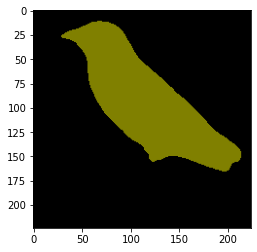

In [8]:
rgb = decode_segmap(om)
plt.imshow(rgb); plt.show()

We have segmented the output of the image.

6. Final Result

In [0]:
def segment(net, path):
  img = Image.open(path)
  plt.imshow(img); plt.axis('off'); plt.show()
  # Comment the Resize and CenterCrop for better inference results
  trf = T.Compose([T.Resize(256), 
                   T.CenterCrop(224), 
                   T.ToTensor(), 
                   T.Normalize(mean = [0.485, 0.456, 0.406], 
                               std = [0.229, 0.224, 0.225])])
  inp = trf(img).unsqueeze(0)
  out = net(inp)['out']
  om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
  rgb = decode_segmap(om)
  plt.imshow(rgb); plt.axis('off'); plt.show()


2020-04-06 12:04:11 URL:https://static.independent.co.uk/s3fs-public/thumbnails/image/2018/04/10/19/pinyon-jay-bird.jpg [182965/182965] -> "bird.png" [1]


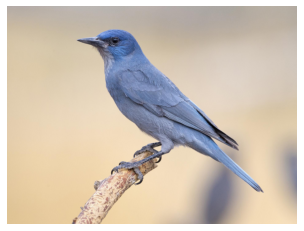

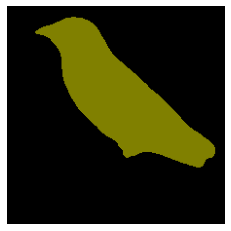

In [18]:
!wget -nv https://static.independent.co.uk/s3fs-public/thumbnails/image/2018/04/10/19/pinyon-jay-bird.jpg -O bird.png

segment(fcn, './bird.png')

# Semantic Segmentation – DeepLab

Semantic Segmentation using DeepLab

In [19]:
dlab = models.segmentation.deeplabv3_resnet101(pretrained=1).eval()

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


we can perform semantic segmentation on the same image using this model!

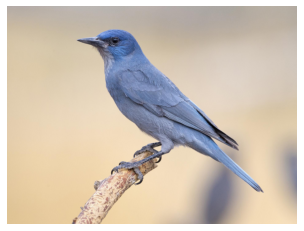

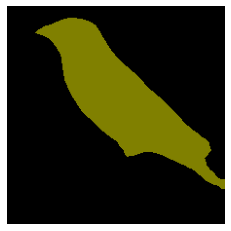

In [20]:
segment(dlab, './bird.png')


Multiple Objects

2020-04-06 13:06:30 URL:https://static.independent.co.uk/s3fs-public/thumbnails/image/2018/04/10/19/pinyon-jay-bird.jpg [182965/182965] -> "bird.png" [1]


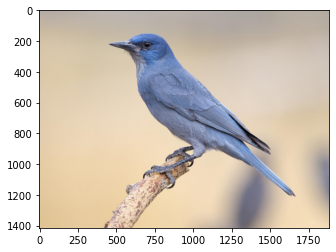

Segmenatation Image on FCN


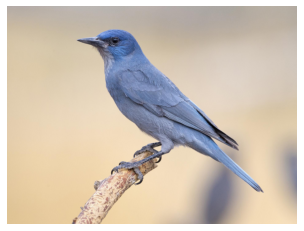

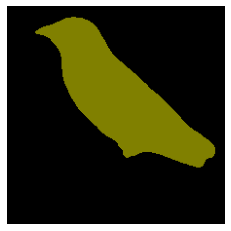

Segmenatation Image on DeepLabv3


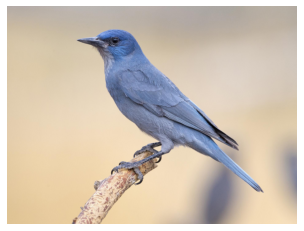

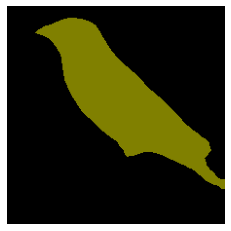

In [38]:
!wget -nv https://static.independent.co.uk/s3fs-public/thumbnails/image/2018/04/10/19/pinyon-jay-bird.jpg -O bird.png
img = Image.open('./bird.png')
plt.imshow(img); plt.show()

print ('Segmenatation Image on FCN')
segment(fcn, path='./bird.png')

print ('Segmenatation Image on DeepLabv3')
segment(dlab, path='./bird.png')

7. Comparison


Compare the two models with each other on the basis of the following 3 metrics.

1. Inference time on CPU and GPU

2. Size of the model.
Model size is the size of the weights file for the model. DeepLab is a slightly bigger model than FCN.

3. GPU memory used while inference.
We have used a NVIDIA GTX 1080 Ti GPU for this and found that both models take around 1.2GB for a 224×224 sized image.

ref(https://www.learnopencv.com/pytorch-for-beginners-semantic-segmentation-using-torchvision/)